In [ ]:
## Test Chronos Pipeline

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from chronos import ChronosPipeline

In [11]:
pipeline = ChronosPipeline.from_pretrained(
    "amazon/chronos-t5-small",
    device_map="cpu",  # use "cpu" for CPU inference and "mps" for Apple Silicon; cuda for gpu
    torch_dtype=torch.bfloat16,
)

In [29]:
df1 = pd.read_csv("https://raw.githubusercontent.com/AileenNielsen/TimeSeriesAnalysisWithPython/master/data/AirPassengers.csv")

#str(df)
df1.describe()
print(df1)

       Month  #Passengers
0    1949-01          112
1    1949-02          118
2    1949-03          132
3    1949-04          129
4    1949-05          121
..       ...          ...
139  1960-08          606
140  1960-09          508
141  1960-10          461
142  1960-11          390
143  1960-12          432

[144 rows x 2 columns]


In [27]:
# context must be either a 1D tensor, a list of 1D tensors,
# or a left-padded 2D tensor with batch as the first dimension
context = torch.tensor(df1["#Passengers"])

prediction_length = 12
forecast = pipeline.predict(
    context,
    prediction_length,
    num_samples=20,
    temperature=1.0,
    top_k=50,
    top_p=1.0,
) # forecast shape: [num_series, num_samples, prediction_length]

In [ ]:
## Plot the outputs

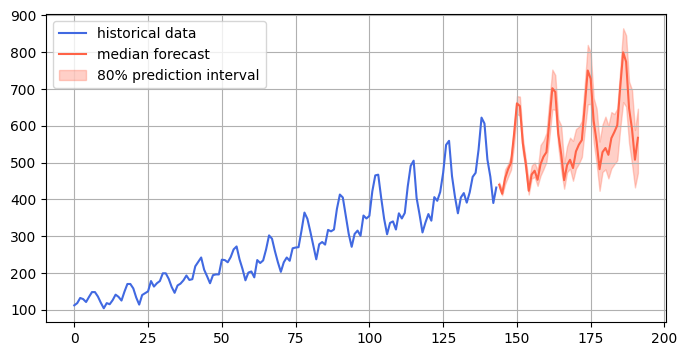

In [18]:
# visualize the forecast
forecast_index = range(len(df), len(df) + prediction_length)
low, median, high = np.quantile(forecast[0].numpy(), [0.1, 0.5, 0.9], axis=0)

plt.figure(figsize=(8, 4))
plt.plot(df["#Passengers"], color="royalblue", label="historical data")
plt.plot(forecast_index, median, color="tomato", label="median forecast")
plt.fill_between(forecast_index, low, high, color="tomato", alpha=0.3, label="80% prediction interval")
plt.legend()
plt.grid()
plt.show()

In [31]:
df2 = pd.read_csv("https://raw.githubusercontent.com/E-DENGUE/Dengue_District_HPC/main/Data/test1.csv")

df2.describe()
print(df2)

    Unnamed: 0        date   district  m_DHF_cases    pop  Dengue_fever_rates
0            1  2004-09-01  VINH HUNG           18  44492           40.456711
1            2  2004-10-01  VINH HUNG           19  44492           42.704306
2            3  2004-11-01  VINH HUNG            8  44492           17.980761
3            4  2004-12-01  VINH HUNG            5  44492           11.237975
4            5  2005-01-01  VINH HUNG            0  44908            0.000000
..         ...         ...        ...          ...    ...                 ...
89          90  2012-02-01  VINH HUNG            2  50133            3.989388
90          91  2012-03-01  VINH HUNG            1  50133            1.994694
91          92  2012-04-01  VINH HUNG            1  50133            1.994694
92          93  2012-05-01  VINH HUNG            2  50133            3.989388
93          94  2012-06-01  VINH HUNG            8  50133           15.957553

[94 rows x 6 columns]


In [35]:
# context must be either a 1D tensor, a list of 1D tensors,
# or a left-padded 2D tensor with batch as the first dimension
context = torch.tensor(df2["Dengue_fever_rates"])

prediction_length = 3
forecast = pipeline.predict(
    context,
    prediction_length,
    num_samples=20,
    temperature=1.0,
    top_k=50,
    top_p=1.0,
) # forecast shape: [num_series, num_samples, prediction_length]


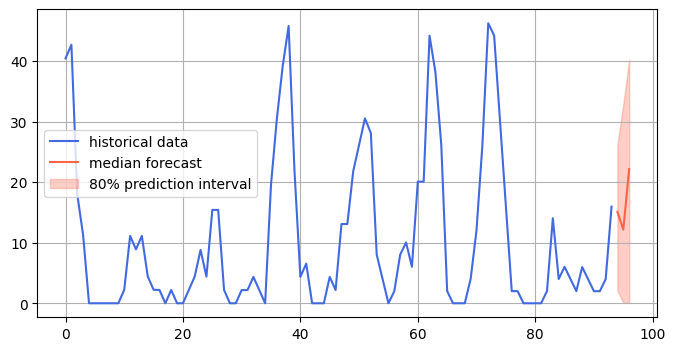

In [36]:
# visualize the forecast
forecast_index = range(len(df2), len(df2) + prediction_length)
low, median, high = np.quantile(forecast[0].numpy(), [0.1, 0.5, 0.9], axis=0)

plt.figure(figsize=(8, 4))
plt.plot(df2["Dengue_fever_rates"], color="royalblue", label="historical data")
plt.plot(forecast_index, median, color="tomato", label="median forecast")
plt.fill_between(forecast_index, low, high, color="tomato", alpha=0.3, label="80% prediction interval")
plt.legend()
plt.grid()
plt.show()